<a href="https://colab.research.google.com/github/dtabuena/CrispyMice/blob/main/New_pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f


try: shutil.rmtree('/content/CrispyMice')
except: None
!git clone https://github.com/dtabuena/CrispyMice
to_import = ['CrispyPipelineFuncs.ipynb']
for i in to_import:
    f = '/content/CrispyMice/' + i
    %run $f


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'EphysLib'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 449 (delta 108), reused 54 (delta 54), pack-reused 307
Receiving objects: 100% (449/449), 240.52 KiB | 8.91 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'CrispyMice'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 171 (delta 49), reused 25 (delta 25), pack-reused 107
Receiving objects: 100% (171/171), 8.15 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [19]:
dataset = {'data_name': 'RNF182',
           'data_source': "https://www.dropbox.com/sh/n9t8p257wnzlijk/AAC9Z36JodisyZjnM3mkJC3Xa?dl=0",
           'file_naming_scheme': ['Rec_date','Virus','GenoType','Sex','Age','Slice_Num','Cell_num','Cell_Type'],
           }

VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree']


'''Unpack'''
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']



''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder(data_source, 'my_ephys_data')
clear_output(wait=False)   
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
abf_recordings_df, _ = purge_wrong_clamp(abf_recordings_df,VC_prot,IC_prot)
_ = cell_prot_lut(abf_recordings_df,protocol_set,csv_name=data_name+'_Recording_LookUp')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:

'''Set Internal Analysis Params'''
spike_args =  {'spike_thresh':20, 'high_dv_thresh': 50,'low_dv_thresh': -30,'window_ms': 2}

func_dict = {}
arg_dict = {}

func_dict['VC - 3min GapFree']= rmp_analyzer
arg_dict['VC - 3min GapFree'] = [True] # [to_plot?]

func_dict['IC - Rheobase']= rheobase_analyzer
arg_dict['IC - Rheobase'] = [spike_args, True, False, False]  # [spike_args, to_plot, verbose, force_singlespike]

func_dict['IC - Gain - D20pA']= gain_analyzer
arg_dict['IC - Gain - D20pA']= [spike_args, 1]  # [spike_args, to_plot [0:2],]
func_dict['IC - Gain - D50pA']= func_dict['IC - Gain - D20pA'] 
arg_dict['IC - Gain - D50pA']= arg_dict['IC - Gain - D20pA']

func_dict['VC - MemTest-10ms-160ms']= membrane_analyzer
arg_dict['VC - MemTest-10ms-160ms']= [True, False, ['Ra', 'Rm', 'Cm', 'tau',	'Cmq',	'Cmf',	'Cmqf', 'Cm_pc']]  # [to_plot, verbose]

func_dict['IC - Latentcy 800pA-1s']= latencey_analyzer 
arg_dict['IC - Latentcy 800pA-1s']= [spike_args, True]  # [spike_args, to_plot]

func_dict['IC - R input']= input_resistance_analyzer 
arg_dict['IC - R input']= [[-30, 10] ,True]  # [dVm_limits, to_plot]

func_dict['VC - Multi IV - 150ms'] = IV_analyzer_v2
arg_dict['VC - Multi IV - 150ms']= [{'IV_Early':(16.5, 30),'IV_Steady_State':(100,120)} ,[False, True]]  # [measure_windows, to_plot]



problem_recs
     my_ephys_data/2022_08_12_RNF182/2022x08x12_RNF182_E4KI_F_P251_s002_c006_CA3xPOS_0006.abf
     my_ephys_data/2022_08_16/2022x08x16_RNF182_E4KI_F_P255_s002_c002_CA3xPOS_0005.abf
     my_ephys_data/2022_08_16/2022x08x16_RNF182_E4KI_F_P255_s002_c002_CA3xPOS_0006.abf
     my_ephys_data/2022_08_16/2022x08x16_RNF182_E4KI_F_P255_s003_c006_CA3xNEG_0005.abf
     my_ephys_data/2022_08_17/2022x08x17_RNF182_E4KI_F_P256_s002_c009_CA3xPOS_0005.abf


<Figure size 432x288 with 0 Axes>

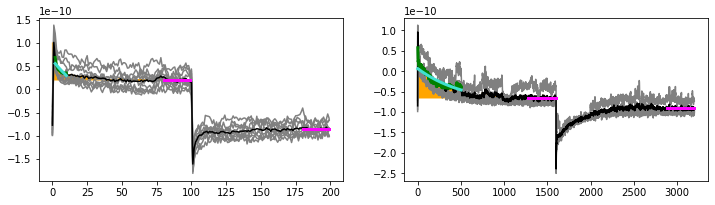

In [21]:


'''Analyze Dataset'''
abf_recordings_df, problem_recs = analysis_iterator(abf_recordings_df,func_dict,arg_dict)
clear_output(wait=True)
print('problem_recs')
_=[print('     '+r) for r in problem_recs]


In [22]:
zip_name = '/content/' + data_name + '_Saved_Figs.zip'
!zip -r $zip_name /content/Saved_Figs 
clear_output()
files.download(data_name + '_Saved_Figs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
'''Sort Cells'''
cell_df = cell_sorting(abf_recordings_df)

'''Consolidate to Cells'''
list_types = ['Recording_name','protocol','abf_timestamp', 'channelList']
any_types = ['Rec_date',	'Virus',	'GenoType',	'Sex',	'Age',	'Slice_Num',  'Cell_num', 'Cell_Type']
cell_df_con = cell_consolidation(cell_df,list_types,any_types)
cols_to_simplify = ['IV_Early', 'IV_Steady_State']
cell_df_nd = simplify_dicts(cell_df_con,cols_to_simplify)     

'''Make Excell Friendly'''
keys_and_data_cols={'Stim_Levels_(pA)': ['Stim_Levels_(pA)', 'Spike_Counts' ],
                'IV_Early_(V_stim)': ['IV_Early_(V_stim)', 'IV_Early_(I_peak)', 'IV_Steady_State_(I_mean)']}
cell_df_csv = csv_frinedly(cell_df_nd,keys_and_data_cols)

''' Convert to Current Density'''
size_col = 'Cmq_160.0'
current_col_list = ['IV_Early_(I_peak)_', 'IV_Steady_State_(I_mean)_']
cell_df_csv = current_density_correction(cell_df_csv, size_col, current_col_list)


'''Abridge DataFrame'''
abrg_exclusions = ['Recording_name', 
                'protocol', 'abf_timestamp', 'channelList',  'Ra_10.0', 'Rm_10.0', 'tau_10.0', 'Cmq_10.0', 'Cmf_10.0',
                'Cmqf_10.0',  'Cmf_160.0', 'Cmqf_160.0', 'Cm_pc_160.0',
                'Gain_R2', 'Stim_Levels_(pA)', 'Spike_Counts', 'Firing_Duration_%', 'Gain_Vh',  'Vhold_spike',
                    'Rin_Rsqr',  'Ramp_AP_thresh', 'Ramp_Vh', 'Ramp_Rheobase', 
                'ap_thresh_us', 'v_half','is_compensated','sum_delta'
                'IV_Early_(range)', 'IV_Early_(I_peak)', 'IV_Early_(I_mean)', 'IV_Early_(V_stim)', 'IV_Steady_State_(range)',
                'IV_Steady_State_(I_peak)', 'IV_Steady_State_(I_mean)', 'IV_Steady_State_(V_stim)', ]

abrg_keep = [c for c in cell_df_csv.columns if c not in abrg_exclusions]
cell_df_csv_abrg = cell_df_csv[abrg_keep]

'''Stratify Cells By Type'''
strat_col = ['Rec_date','Cell_Type']
strat_df_dict = stratify_rec(cell_df_csv_abrg,strat_col)
strat_df_dict,_ = flatten_dict(strat_df_dict,{})
write_strat_dfs(strat_df_dict, dataset['data_name']+'_results_stratified')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:


# def write_strat_dfs(strat_dfs, xl_file_name='stratified_data.xlsx'):
#     if '.xlsx' not in xl_file_name: xl_file_name = xl_file_name+'.xlsx'
#     options = {}
#     options['strings_to_formulas'] = False
#     options['strings_to_urls'] = False
#     writer = pd.ExcelWriter(xl_file_name, options=options)
#     for k in strat_dfs.keys():
#         cur_df = strat_dfs[k]
#         strat_dfs[k].to_excel(writer, sheet_name=str(k))
#     writer.save()
#     writer.close()
#     files.download(xl_file_name)
#     return None

# def flatten_dict(my_dict,flat_dict = {} ):
#     for k in my_dict.keys():
#         if isinstance(my_dict[k], dict):
#             sub_dict, sub_keys = flatten_dict(my_dict[k],flat_dict)
#             for sk in sub_keys:
#                 flat_dict[k+'_'+sk] = sub_dict[sk]
#         else:
#             flat_dict = my_dict
#     return flat_dict, list(flat_dict.keys()) 